<a href="https://colab.research.google.com/github/JuanZapa7a/Medical-Image-Processing/blob/main/Google_Notebook_and_Tensorflow_(III).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Create a Dataset from Files

To use a manually downloaded dataset with TensorFlow Datasets (TFDS), the dataset structure and metadata must be properly set up to be recognized by TFDS. Unfortunately, TFDS expects a certain structure for its datasets, which can be challenging when using manually downloaded files.

## Download the Dataset:
---
**Download the cell_images.zip file from the provided URL.**

---

In [1]:
import tensorflow as tf
import pathlib
import zipfile
import os

dataset_url = 'https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip'

data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='cell_images.zip', extract=False)
data_dir = pathlib.Path(data_dir)

353452851/353452851 [==============================] - 7s 0us/step


## Extract the Dataset

---
**Unzip the downloaded file.**

---

In [2]:
# Convert to a pathlib Path object
data_dir = pathlib.Path(data_dir)

# Define the malaria dataset directory path
malaria_dir = pathlib.Path('/content/datasets/malaria')
# Ensure the malaria directory exists
malaria_dir.mkdir(parents=True, exist_ok=True)

# Extract the zip file into the manual directory
with zipfile.ZipFile(data_dir, 'r') as zip_ref:
    zip_ref.extractall(malaria_dir)

# Verify the extraction
print(f'Extracted files to {malaria_dir}')

Extracted files to /content/datasets/malaria


## Inspect the Dataset

The dataset contains several thousand photos of cell images in two subdirectories (classes) with one cell image per class. The directory structure is as follows thanks to this snipet:

---
**Display the datapath structure.**

---

In [3]:
import os

def print_directory_tree(root_dir, level=0):
    """
    Recursively prints the directory tree structure, only listing directories.
    """
    prefix = " " * (level * 4) + "|-- " if level > 0 else ""
    print(prefix + os.path.basename(root_dir))

    if os.path.isdir(root_dir):
        for item in os.listdir(root_dir):
            item_path = os.path.join(root_dir, item)
            if os.path.isdir(item_path):
                print_directory_tree(item_path, level + 1)

# Define the data directory
data_dir = '/content/datasets/malaria/cell_images'

# Print the directory tree
print_directory_tree(data_dir)


cell_images
    |-- Uninfected
    |-- Parasitized


## Load the Dataset

Using Keras `image_dataset_from_directory` you can create train and validation sets. The `tf.keras.preprocessing.image_dataset_from_directory` utility offers incredible convenience for loading and parsing images off disk!


The `tf.keras.preprocessing.image_dataset_from_directory` function in TensorFlow expects a specific directory structure to correctly load an image dataset from a directory. This structure follows a convention where images are organized into subdirectories based on their labels or classes.

### Directory Structure

The directory structure should be as follows:

```
dataset_directory/
    class_a/
        img1.jpg
        img2.jpg
        ...
    class_b/
        img1.jpg
        img2.jpg
        ...
    ...
```

### Using `image_dataset_from_directory`

Here's an example of how to use the `image_dataset_from_directory` function to load this dataset:

```python
import tensorflow as tf

# Path to the main dataset directory
dataset_directory = "path/to/dataset"

# Create the image dataset
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_directory,
    validation_split=0.2,       # Split the dataset into training and validation
    subset="training",          # Specify that this is the training subset
    seed=123,                   # Seed for randomization
    image_size=(256, 256),      # Size to resize images to
    batch_size=32               # Batch size
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_directory,
    validation_split=0.2,       # Split the dataset into training and validation
    subset="validation",        # Specify that this is the validation subset
    seed=123,                   # Seed for randomization
    image_size=(256, 256),      # Size to resize images to
    batch_size=32               # Batch size
)
```

### Important Parameters of `image_dataset_from_directory`

- `directory`: Path to the main dataset directory.
- `validation_split`: Fraction of the dataset to reserve for validation.
- `subset`: Specifies whether the subset is training (`"training"`) or validation (`"validation"`).
- `seed`: Seed for randomization to ensure consistent training and validation splits.
- `image_size`: A tuple specifying the size to resize all images to.
- `batch_size`: Size of the batches of data.

### Additional Notes

- Images should be in a format supported by TensorFlow (such as JPEG or PNG).
- The names of the subdirectories will be used as class labels.
- The function can also handle automatic splitting of training and validation datasets if the `validation_split` parameter is specified.

By following this structure and using the `image_dataset_from_directory` function correctly, you can load and prepare your image dataset for use in deep learning models with TensorFlow.


We set batch size initially to 32 because it tends to be a good size for many of the datasets with which we work. We set image height and width at 64 because we get good results and the model trains really fast. **Feel free to experiment with these parameters.**

Our inspection revealed that image size differs. Since TensorFlow models expect images of the same size, we must resize them.

## Create Training and Test/Val Sets
The `tf.keras.preprocessing.image_dataset_from_directory` utility generates a tf.data. Dataset from image files in a directory. The utility is very useful because it allows us to conveniently split, seed, resize, and batch data. Let’s split data into 80% training and 20% test sets. Theoretically we must set this split based on numerous experiments. Of course, you can tweak
the sizes with your own experiment. The combination of the `validation_split` and `subset` parameters determines the train and test splits.

---
**Create Training and Test Sets**

---

In [4]:
import tensorflow as tf
import pathlib

# Define the data directory
data_dir = pathlib.Path('/content/datasets/malaria/cell_images')

# Load the dataset using image_dataset_from_directory
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,  # Split 80% for training and 20% for validation
    subset="training",
    seed=123,
    image_size=(64, 64),  # Resize images to 224x224
    batch_size=32
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(64, 64),
    batch_size=32
)

Found 27558 files belonging to 2 classes.
Using 22047 files for training.
Found 27558 files belonging to 2 classes.
Using 5511 files for validation.


## Display images and labels from some batch

---
**Show a batch of images and labels**

---

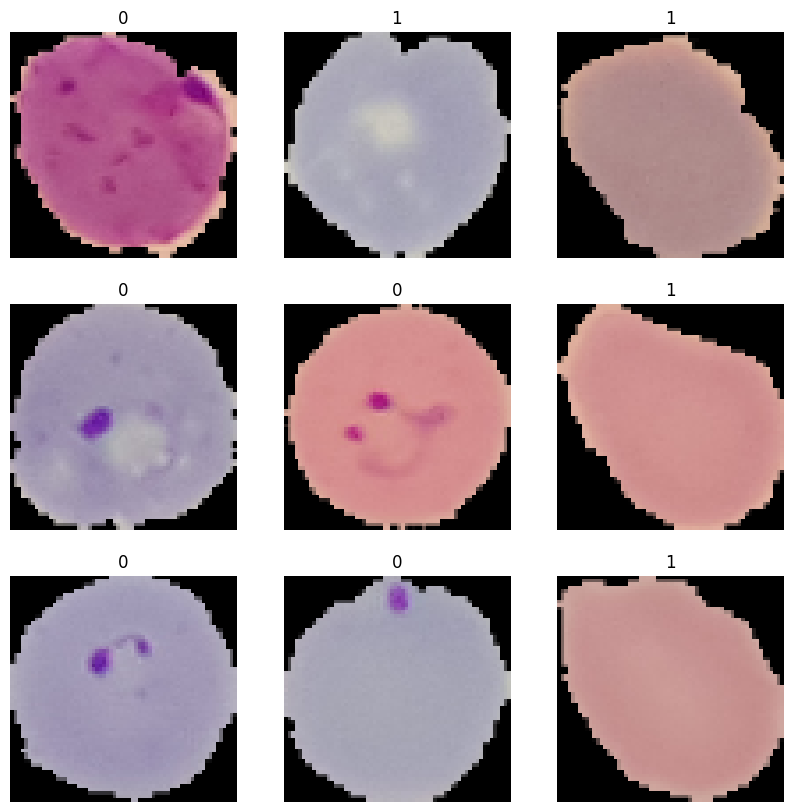

In [5]:
# Show a batch of images and labels
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(str(labels[i].numpy()))
        plt.axis("off")

plt.show()

## Count the number of images

Count the number of images in the "Parasitized" and "Uninfected" directories

---
**Count number of images in both classes**

---

In [6]:
import os

# Define the data directory
data_dir = '/content/datasets/malaria/cell_images'

# Count the number of images in each subdirectory
parasitized_count = len(os.listdir(os.path.join(data_dir, 'Parasitized')))
uninfected_count = len(os.listdir(os.path.join(data_dir, 'Uninfected')))

# Print the counts
print(f'Parasitized: {parasitized_count} images')
print(f'Uninfected: {uninfected_count} images')


Parasitized: 13780 images
Uninfected: 13780 images


## Display some images

From the "Parasitized" and "Uninfected" directories, you can use the matplotlib library to display 4 images from each directory:

---
**Display some images from both classes**

---

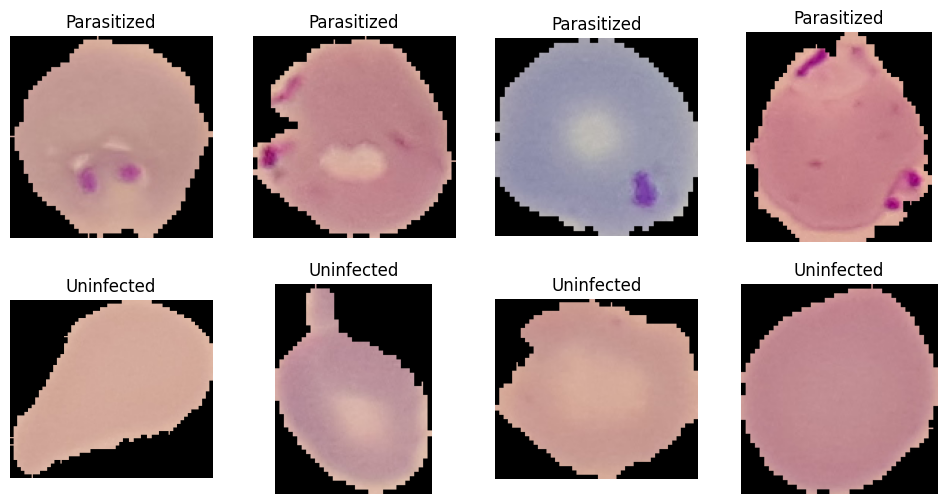

In [7]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define the data directory
data_dir = '/content/datasets/malaria/cell_images'

# Define the number of images to display from each class
num_images_per_class = 4

# Define the paths to the image directories
parasitized_dir = os.path.join(data_dir, 'Parasitized')
uninfected_dir = os.path.join(data_dir, 'Uninfected')

# Get the list of images in each directory
parasitized_images = os.listdir(parasitized_dir)[:num_images_per_class]
uninfected_images = os.listdir(uninfected_dir)[:num_images_per_class]

# Display Parasitized images
plt.figure(figsize=(12, 6))
for i, image_name in enumerate(parasitized_images):
    img_path = os.path.join(parasitized_dir, image_name)
    img = mpimg.imread(img_path)
    plt.subplot(2, 4, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Parasitized')

# Display Uninfected images
for i, image_name in enumerate(uninfected_images):
    img_path = os.path.join(uninfected_dir, image_name)
    img = mpimg.imread(img_path)
    plt.subplot(2, 4, i+5)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Uninfected')

plt.show()


Notice that images are not of the same size!

# Parse Data

---
***Inspect* Tensors**

---

In [ ]:
train_ds, test_ds

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

Take the first batch from the training set and preserve shapes:

---
**Inspect the first batch**

---

In [8]:
for img, lbl in train_ds.take(1):
  print (img.shape, lbl.shape)
cell_shape, just_img = img.shape[1:],\
                         img.shape[1:3]


(32, 64, 64, 3) (32,)


We take the first batch to help us inspect a batch from the dataset. We preserve the shape of the batch and batch size for use in the model. Batch size is 32, and images are resized to 224 × 224 × 3. The 3 value indicates that images have three channels, which means they are RGB (color). Labels have shape (32,) that corresponds to the 32 batch size of labels.


## Get Class Names
We already identified the classes from the directory names. But we can now access them with the `class_names` method:

In [9]:
# Check the class names
class_names = train_ds.class_names
print(class_names)


['Parasitized', 'Uninfected']


# Display images from a batch in memory

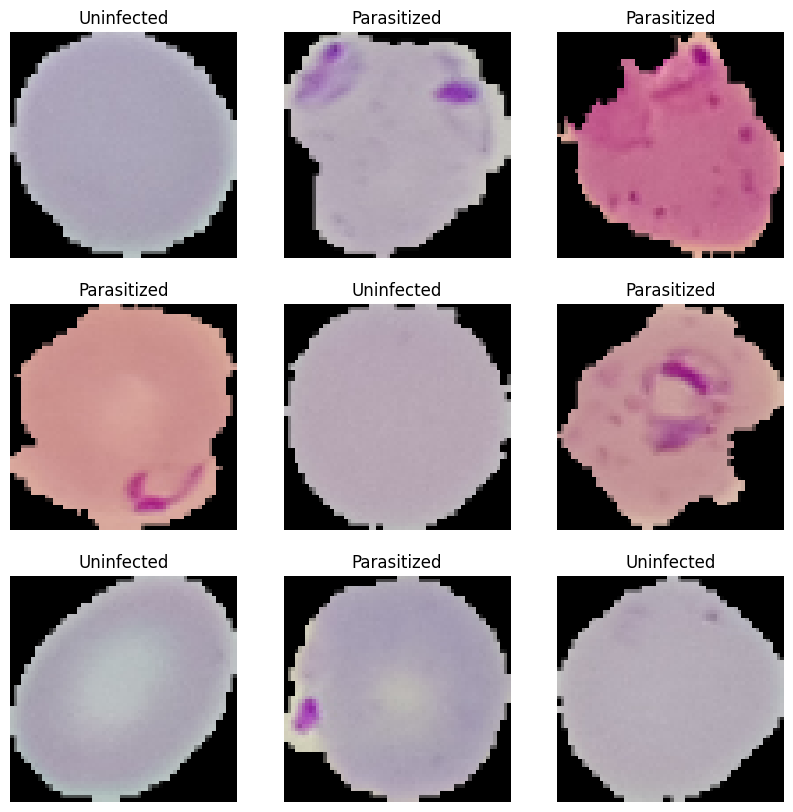

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

## Scale the Data
As noted earlier in the chapter, a pixel is represented by 256 values. So RGB channel values are in the [0, 255] range. Since neural networks work better with small values, data is typically scaled to be in the [0, 1] range.

Create a function to scale images:

In [11]:
def format_image(image, label):
  image = tf.image.resize(image, just_img) / 255.0
  return image, label

The function is used when we configure the input pipeline.
## Configure the Dataset for Performance
Use buffered prefetching to get data from disk to mitigate I/O issues. Cache data to keep images in memory after they’re loaded off disk. Caching saves operations like file opening and data reading from being executed during each epoch.
## Build the Input Pipeline
Scale, shuffle the training set, and cache and prefetch train and test sets:


In [12]:
shuffle_size = 100

train_cds = train_ds.map(format_image).\
  shuffle(shuffle_size).cache().prefetch(1)
test_cds = test_ds.map(format_image).\
  cache().prefetch(1)

In [13]:
import numpy as np

# Verify min and max values in the training and test datasets
train_images = np.concatenate([x.numpy() for x, _ in train_cds], axis=0)
test_images = np.concatenate([x.numpy() for x, _ in test_cds], axis=0)

print("Training dataset - min value:", train_images.min(), "max value:", train_images.max())
print("Test dataset - min value:", test_images.min(), "max value:", test_images.max())

Training dataset - min value: 0.0 max value: 1.0
Test dataset - min value: 0.0 max value: 1.0


---
**Note** since training and test data have already been batched by the utility, do not batch when building the input pipeline!

---

## Build the Model
Since we are working with large color images, we need to build a convolutional neural network (CNN) model to garner respectable performance because flower images are color with higher pixel counts.

We need additional libraries for a CNN:

In [14]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

Get the number of classes for use in the model:

In [15]:
num_classes = len(class_names)
num_classes

2

Clear any previous models and generate a random seed:

In [16]:
import numpy as np

tf.keras.backend.clear_session()
np.random.seed(0)
tf.random.set_seed(0)

Create a multilayer CNN

In [17]:
cell_model = tf.keras.Sequential([
  Conv2D(32, 3, activation='relu',
         input_shape=cell_shape),
  MaxPooling2D(),
  Conv2D(32, 3, activation='relu'),
  MaxPooling2D(),
  Conv2D(32, 3, activation='relu'),
  MaxPooling2D(),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(num_classes, activation='softmax')
])

The first layer scales the data. The second layer contains 32 neurons with a 3 × 3 convolutional kernel (or filter). Activation is relu. The third layer uses maximum pooling to reduce the spatial size of a layer by just keeping the maximum values. As such,
the pooling layer reduces image dimensionality without losing important features or patterns. The next four layers repeat the same pattern as the second and third layers. The Flatten layer converts pooled data into a single column because a Dense layer expects data in this form. The final Dense layer enables classification and prediction.

Compile and Train the Model
Compile with `SparseCategoricalCrossentropy()`:


In [18]:
cell_model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

In [19]:
# Print the model summary
cell_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 6, 6, 32)          0

Since softmax is applied to outputs, we **don’t** set from_logits=True. Train the model:

In [21]:
history = cell_model.fit(
    train_cds,
    validation_data=test_cds,
    epochs=30)


Epoch 1/30
689/689 [==============================] - 5s 7ms/step - loss: 0.1441 - accuracy: 0.9536 - val_loss: 0.1352 - val_accuracy: 0.9570
Epoch 2/30
689/689 [==============================] - 4s 6ms/step - loss: 0.1281 - accuracy: 0.9590 - val_loss: 0.1299 - val_accuracy: 0.9570
Epoch 3/30
689/689 [==============================] - 4s 5ms/step - loss: 0.1196 - accuracy: 0.9600 - val_loss: 0.1277 - val_accuracy: 0.9570
Epoch 4/30
689/689 [==============================] - 4s 5ms/step - loss: 0.1094 - accuracy: 0.9633 - val_loss: 0.1299 - val_accuracy: 0.9574
Epoch 5/30
689/689 [==============================] - 4s 6ms/step - loss: 0.1009 - accuracy: 0.9651 - val_loss: 0.1346 - val_accuracy: 0.9559
Epoch 6/30
689/689 [==============================] - 4s 6ms/step - loss: 0.0906 - accuracy: 0.9699 - val_loss: 0.1399 - val_accuracy: 0.9528
Epoch 7/30
689/689 [==============================] - 4s 5ms/step - loss: 0.0789 - accuracy: 0.9731 - val_loss: 0.1557 - val_accuracy: 0.9503
Epoch 

The model is overfitting because validation accuracy is low compared to training accuracy. But we have not made any attempt to tune the model. In the next chapter, we explore a powerful technique to mitigate overfitting.

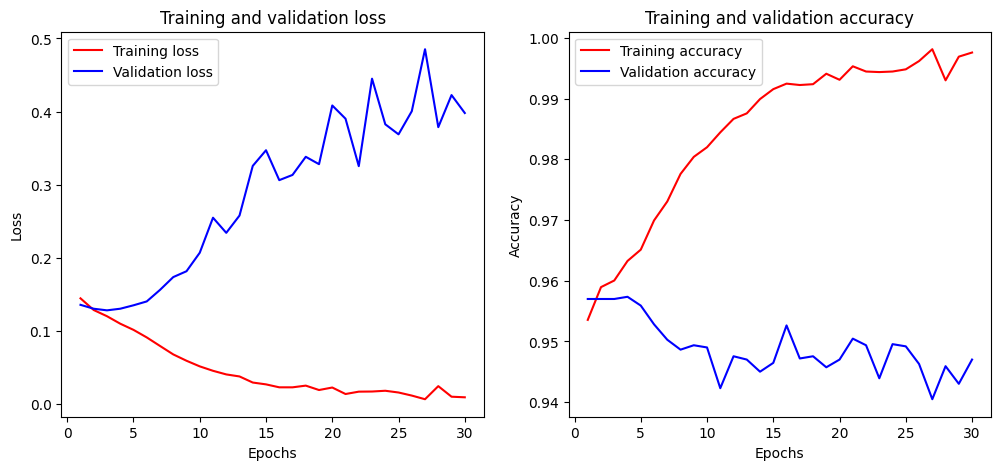

In [22]:
import matplotlib.pyplot as plt

# Get the training and validation loss and accuracy from the history
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Plot the loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

Test Loss: 0.3979349136352539
Test Accuracy: 0.9470150470733643


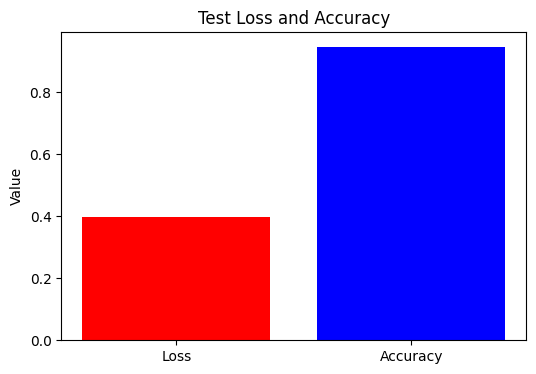

In [23]:
import matplotlib.pyplot as plt

# Evaluate the model on the test set
test_loss, test_accuracy = cell_model.evaluate(test_cds, verbose=0)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Plot the test data
plt.figure(figsize=(6, 4))
plt.bar(['Loss', 'Accuracy'], [test_loss, test_accuracy], color=['red', 'blue'])
plt.title('Test Loss and Accuracy')
plt.ylabel('Value')
plt.show()

173/173 [==============================] - 1s 3ms/step
Length of y_true: 5511
Length of y_pred_classes: 5511


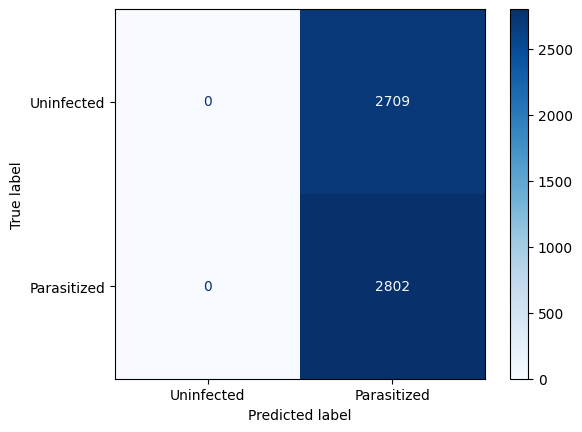

In [24]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Make predictions on the test set
y_pred = np.max(np.abs((cell_model.predict(test_cds))),1)
y_pred_classes = (y_pred > 0.5).astype("int32").flatten()


# Get true labels
y_true = np.concatenate([y.numpy() for x, y in test_cds], axis=0)

print("Length of y_true:", len(y_true))
print("Length of y_pred_classes:", len(y_pred_classes))

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=['Uninfected', 'Parasitized'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

------------------------------------------------------------------ HASTA AQUI --------------

# Get Flowers from Google Cloud Storage
We demonstrated input pipelining with data from memory and from files. We can also pipeline data from cloud storage. Flowers data is hosted in a public bucket on Google Cloud Storage (GCS). So we can grab flower files from GCS. We can read flowers as JPEG files or as TFRecord files. For data modeling, we use TFRecord files. For optimal performance, we read from multiple TFRecord files at once. The TFRecord format is a simple format for storing a sequence of binary records. A TFRecord file contains a sequence of records, which can only be read sequentially.

## Read Flowers as JPEG Files and Perform Simple Processing
Read JPEG files based on a GCS pattern:


In [ ]:
GCS_PATTERN = 'gs://flowers-public/*/*.jpg'
filenames = tf.io.gfile.glob(GCS_PATTERN)

GCS_PATTERN is a glob pattern that supports the “*” and “?” wildcards. **Globs** (also known as glob patterns) are patterns that can expand a wildcard pattern into a list of pathnames that match the given pattern.
Get the number of JPEG images:

In [ ]:
num_images = len(filenames)
print ('Pattern matches {} images.'.format(num_images))

Create a dataset of filenames from GCS_PATTERN and peruse its contents:

In [ ]:
filenames_ds = tf.data.Dataset.list_files(GCS_PATTERN)
for filename in filenames_ds.take(5):
  print (filename.numpy().decode('utf-8'))


We need the data in (image, label) tuples to work with the images and labels independently. So create a function to return a dataset of (image, label) tuples

In [ ]:
def decode_jpeg_and_label(filename):
  bits = tf.io.read_file(filename)
  image = tf.image.decode_jpeg(bits)
  label = tf.strings.split(
      tf.expand_dims(filename, axis=-1), sep='/')
  label = label.values[-2]
  return image, label

Map the function to each filename to create a dataset of (image, label) tuples:

In [ ]:
ds = filenames_ds.map(decode_jpeg_and_label)

Peruse:

In [ ]:
for image, label in ds.take(5):
  print (image.numpy().shape,
         label.numpy().decode('utf-8'))

Display an image:

In [ ]:
for img, lbl  in ds.take(1):
  plt.axis('off')
  plt.title(lbl.numpy().decode('utf-8'))
  fig = plt.imshow(img)


Although we don’t train with this dataset, let’s see how to convert text labels to encoded labels

In [ ]:
for img, lbl in ds.take(1):
  label = lbl.numpy().decode('utf-8')
matches = tf.stack([tf.equal(label, s)\
                    for s in class_names], axis=-1)
one_hot = tf.cast(matches, tf.float32)
print (matches.numpy(), one_hot.numpy())
new_label = tf.math.argmax(one_hot)
new_label.numpy()

Take a label. Compare it against the class name list to find its position in the list. Create a one-hot vector. Convert the one-hot vector into a label tensor. We don’t train with this dataset because it is not the way to model complex data from GCS. But it is a simple way to load and inspect the data.
# Read and Process Flowers as TFRecord Files
The best way to model complex data from GCS is as TFRecord files. A TFRecord file stores data as a sequence of binary strings. Binary strings are very efficient to process.
## Read TFRecord Files
Read TFRecord files based on a GCS pattern:


In [ ]:
piece1 = 'gs://flowers-public/'
piece2 = 'tfrecords-jpeg-192x192-2/*.tfrec'
TFR_GCS_PATTERN = piece1 + piece2
tfr_filenames = tf.io.gfile.glob(TFR_GCS_PATTERN)

Get the number of buckets:

In [ ]:
num_images = len(tfr_filenames)
print ('Pattern matches {} image buckets.'.format(num_images))

We grabbed 16 buckets. Since there are 3670 flower files, 15 buckets contain 230 images (15 × 230 = 3,450), and the final bucket contains 220 images. Add 3,450 to 220 to get 3,670.

Display a file:

In [ ]:
filenames_tfrds = tf.data.Dataset.list_files(TFR_GCS_PATTERN)
for filename in filenames_tfrds.take(1):
  print (filename.numpy())

Set Parameters for Training
Set parameters for image resizing, pipelining, and number of epochs:


In [ ]:
IMAGE_SIZE = [192, 192]
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64
SHUFFLE_SIZE = 100
EPOCHS = 5

Use AUTOTUNE to prompt the tf.data runtime, which tunes the value dynamically at runtime.

---
**Note** autotune is experimental, which means that the operation may change in the future.

---
Set validation split and class labels:


In [ ]:
VALIDATION_SPLIT = 0.19
CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

Create data splits, validation steps, and steps per epoch as shown in Listing 1-8.

In [ ]:
split = int(len(tfr_filenames) * VALIDATION_SPLIT)
training_filenames = tfr_filenames[split:]
validation_filenames = tfr_filenames[:split]
print ('Splitting dataset into {} training files and {}'
        ' validation files'.format(
            len(tfr_filenames), len(training_filenames),
            len(validation_filenames)), end = ' ')
print ('with a batch size of {}.'.format(BATCH_SIZE))
validation_steps = int(3670 // len(tfr_filenames) *\
                       len(validation_filenames)) // BATCH_SIZE
steps_per_epoch = int(3670 // len(tfr_filenames) *\
                      len(training_filenames)) // BATCH_SIZE
print ('There are {} batches per training epoch and {} '\
       'batches per validation run.'\
       .format(BATCH_SIZE, steps_per_epoch, validation_steps))

# Create Functions to Load and Process TFRecord Files
Create a function to parse a TFRecord file

In [ ]:
def read_tfrecord(example):
  features = {
      'image': tf.io.FixedLenFeature([], tf.string),
      'class': tf.io.FixedLenFeature([], tf.int64)
  }
  example = tf.io.parse_single_example(example, features)
  image = tf.image.decode_jpeg(example['image'], channels=3)
  image = tf.cast(image, tf.float32) / 255.0
  image = tf.reshape(image, [*IMAGE_SIZE, 3])
  class_label = example['class']
  return image, class_label

The function accepts a TFRecord file. A dictionary holds datatypes common to TFRecords. The tf.string datatype converts the image to byte strings (list of bytes). The
tf.int64 converts the class label to a 64-bit integer scalar value. The TFRecord file is parsed into (image, label) tuples. The image element, a JPEG-encoded image, is decoded into a uint8 image tensor. The image tensor is scaled to the [0, 1] range for faster training. It is then reshaped to a standard size for model consumption. The class label element is cast to a scalar.

Create a function to load TFRecord files as `tf.data.Dataset`

In [ ]:
def load_dataset(filenames):
  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False
  dataset = tf.data.TFRecordDataset(
      filenames, num_parallel_reads=AUTO)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
  return dataset

The function accepts TFRecord files. For optimal performance, code is included
to read from multiple TFRecord files at once. The options setting allows order-altering optimizations. As such, n files are read in parallel, and data order is disregarded in favor of reading speed.

Create a function to build an input pipeline from TFRecord files

In [ ]:
def get_batched_dataset(filenames, train=False):
  dataset = load_dataset(filenames)
  dataset = dataset.cache()
  if train:
    dataset = dataset.repeat()
    dataset = dataset.shuffle(SHUFFLE_SIZE)
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(AUTO)
  return dataset

The function accepts TFRecord files and calls the load_dataset function. The function continues by building an input pipeline by caching, repeating, shuffling, batching, and prefetching the dataset. Repeating and shuffling are only mapped to training data to follow best practices for a Keras dataset.

## Create Training and Test Sets
Instantiate the datasets:


In [ ]:
training_dataset = get_batched_dataset(
    training_filenames, train=True)
validation_dataset = get_batched_dataset(
    validation_filenames, train=False)
training_dataset, validation_dataset


Display an image and preserve the shape for the model:

In [ ]:
for img, lbl in training_dataset.take(1):
  plt.axis('off')
  plt.title(CLASSES[lbl[0].numpy()])
  fig = plt.imshow(img[0])
  tfr_flower_shape = img.shape[1:]


## Model Data
Clear and seed:

In [ ]:
tf.keras.backend.clear_session()
np.random.seed(0)
tf.random.set_seed(0)


Create the model as shown

In [ ]:
tfr_model = Sequential([
  Conv2D(32, (3, 3), activation = 'relu',
         input_shape=tfr_flower_shape),
  MaxPooling2D(2, 2),
  Conv2D(64, (3, 3), activation='relu'),
  MaxPooling2D(2, 2),
  Conv2D(128, (3, 3), activation='relu'),
  MaxPooling2D(2),
  Conv2D(128, (3, 3), activation='relu'),
  MaxPooling2D(2, 2),
  Flatten(),
  Dense(512, activation='relu'),
  Dense(num_classes, activation='sigmoid')
])

Inspect

In [ ]:
tfr_model.summary()

Compile:

In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True)
tfr_model.compile(optimizer='adam',
              loss=loss,
              metrics=['accuracy'])


Train:

In [ ]:
history = tfr_model.fit(training_dataset, epochs=EPOCHS,
                    verbose=1, steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    validation_data=validation_dataset)


## Summary
We built ML input pipeline examples from three types of data. The first experiments built pipelines from data loaded into memory. We then built a pipeline from external files. The final experiment built a pipeline from cloud storage.